In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook
from  tqdm import tqdm_notebook
import time
from os.path import join, expanduser
from os import environ
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(join(expanduser('~'),"MNIST_data"), one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/phuijse/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/phuijse/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /home/phuijse/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/phuijse/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<IPython.core.display.Javascript object>


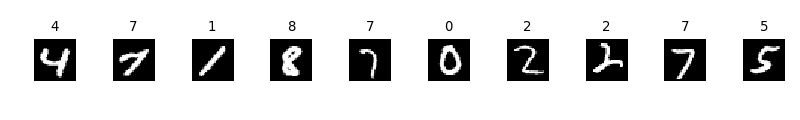

In [2]:
npix = 28

fig,ax = plt.subplots(1, 10, figsize=(10, 1.5), dpi=80)
P = np.random.permutation(10000)
for i in range(10):
    idx = P[i]
    ax[i].matshow(np.reshape(mnist.train.images[idx, :], (npix, npix)), cmap=plt.cm.Greys_r)
    ax[i].set_title(str(np.argmax(mnist.train.labels[idx])))
    ax[i].axis('off');
fig.tight_layout()

In [3]:
"""

Use this to select GPU and limit the memory usage

"""
environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3

<IPython.core.display.Javascript object>


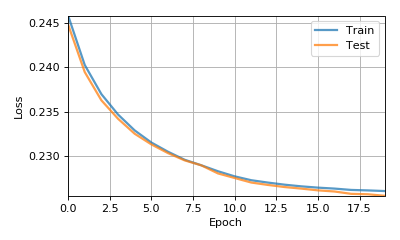

Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
nepochs = 20
batch_size = 32
metrics = np.zeros(shape=(nepochs, 2))

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784])
#with tf.variable_scope('encoder'):
#    h = tf.layers.dense(inputs=x, units=64, use_bias=True, activation=tf.nn.relu)
with tf.variable_scope('latent'):
    z = tf.layers.dense(inputs=x, units=2, use_bias=True, activation=None)
with tf.variable_scope('decoder'):
    #h = tf.layers.dense(inputs=z, units=64, use_bias=True, activation=tf.nn.relu)
    y = tf.layers.dense(inputs=z, units=784, use_bias=True, activation=None)
    x_hat = tf.nn.sigmoid(y)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=x)
reg = tf.reduce_mean(tf.norm(z, ord=2))
loss = tf.reduce_mean(cross_entropy)
beta = 0.0
train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss + beta*reg)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=80)
ax.plot(0, linewidth=2, alpha=0.75, label='Train'); 
ax.plot(0, linewidth=2, alpha=0.75, label='Test');
ax.set_ylabel('Loss'); ax.set_xlabel('Epoch')
line1, line2 = ax.lines
plt.legend(); plt.grid(); plt.tight_layout();

with tf.Session(config=config) as sess:    
    tf.global_variables_initializer().run()
    for epoch in tqdm_notebook(range(nepochs), desc='Train epoch'):
        for _ in range(int(mnist.train.images.shape[0]/batch_size)):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step, feed_dict={x: batch_xs})
        metrics[epoch, 0] = sess.run(loss, feed_dict={x: mnist.train.images})
        metrics[epoch, 1] = sess.run(loss, feed_dict={x: mnist.test.images})
        if epoch > 0:
            line1.set_data(range(epoch+1), metrics[:epoch+1, 0])
            line2.set_data(range(epoch+1), metrics[:epoch+1, 1])
            ax.set_xlim([0, epoch])
            ax.set_ylim([np.amin(metrics[:epoch+1,:]), np.amax(metrics[:epoch+1,:])])
            fig.canvas.draw()
    z_eval = sess.run(z, feed_dict={x: mnist.test.images})
    x_hat_eval = sess.run(x_hat, feed_dict={x: mnist.test.images})


<IPython.core.display.Javascript object>


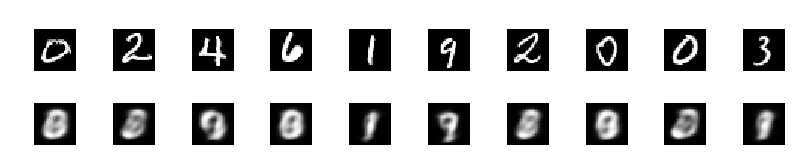

In [5]:
fig, axs = plt.subplots(2, 10, figsize=(10, 2), dpi=80)
P = np.random.permutation(10000)
for i in range(10):
    idx = P[i]
    axs[0, i].matshow(np.reshape(mnist.test.images[idx, :], (npix, npix)), cmap=plt.cm.Greys_r)
    axs[0, i].axis('off');
    axs[1, i].matshow(np.reshape(x_hat_eval[idx, :], (npix, npix)), cmap=plt.cm.Greys_r)
    axs[1, i].axis('off');
plt.tight_layout();

<IPython.core.display.Javascript object>


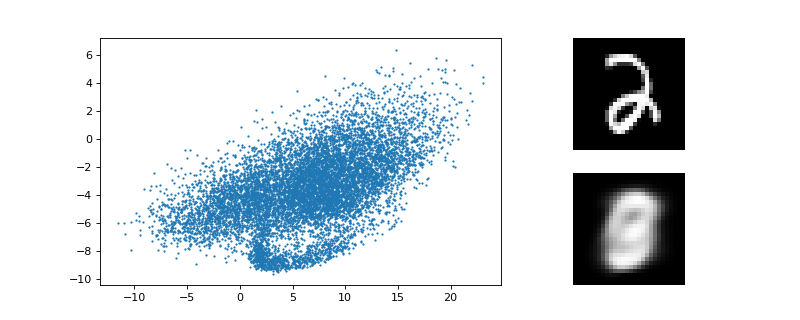

In [6]:
fig = plt.figure(figsize=(10, 4), dpi=80)
ax_main = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
ax_ori = plt.subplot2grid((2, 3), (0, 2))
ax_rec = plt.subplot2grid((2, 3), (1, 2))
ax_ori.axis('off'); ax_rec.axis('off');
ax_main.scatter(z_eval[:, 0], z_eval[:, 1], s=1)

def onclick(event):
    z_closest = [event.xdata, event.ydata]
    idx = np.argmin(np.sum((z_eval - z_closest)**2, axis=1))
    ax_ori.matshow(mnist.test.images[idx].reshape(npix, npix), cmap=plt.cm.Greys_r)
    ax_rec.matshow(x_hat_eval[idx].reshape(npix, npix), cmap=plt.cm.Greys_r)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)